In [1]:
# Load data pkl file
import pickle5 as pickle
from tqdm import tqdm
import pandas as pd
with open('data/reduced.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partition.csv')

# Add ion info in dict
print('\nAdding ion info to dict...')
for key in tqdm(data_dict.keys()):
    try:
        data_dict[key].append(df[df['pdb_chain']==key]['LigID'].item())
        data_dict[key].append(df[df['pdb_chain']==key]['partitions'].item())
    except:
        pass
        #print('Problem with %s'%(key))


Adding ion info to dict...


100%|██████████| 28310/28310 [01:14<00:00, 380.73it/s]


In [2]:
import numpy as np
import os
from utils import ProtEmbDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
model_name = 'esm1_t34_670M_UR50D'
holdout_batches = []

holdout_fold = 6
for datapoint in os.listdir(data_path+model_name+'_batch128_CV/'):
    if datapoint.endswith('fold%s.pickle'%(holdout_fold)):
        holdout_batches.append(datapoint)
    else:
        pass

data_list = np.array(os.listdir(data_path+model_name+'_batch128_CV/'))
holdout_indices = list(np.where(np.isin(data_list, holdout_batches))[0])
protein_dataset = ProtEmbDataset(model_name)
sampler_holdout = SubsetRandomSampler(holdout_indices)
dataloader_holdout = DataLoader(protein_dataset, batch_size=1, sampler = sampler_holdout, num_workers=4)

/home/dell4/miniconda3/envs/ion/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(dataloader_holdout), dataloader_holdout.dataset[0][0].shape

(9, torch.Size([42185, 1280]))

/home/dell4/miniconda3/envs/ion/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


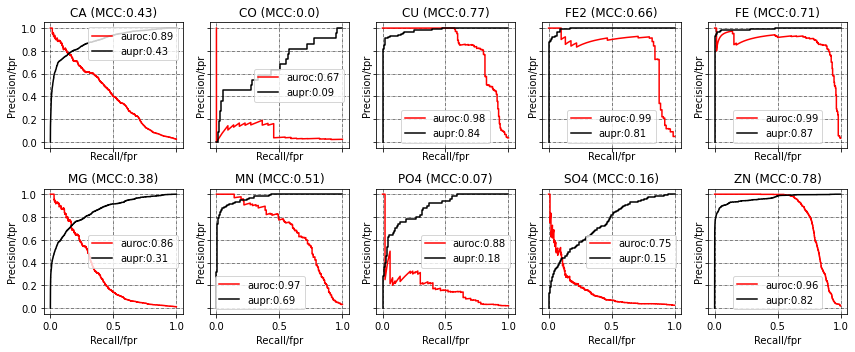

In [46]:
# External validation of fold 6 
# All labels considered (nx11)
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

import torch.nn as nn
m = nn.Sigmoid()

cpt_fold = 1

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'      # For inference
trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
trained_model.load_state_dict(torch.load('checkpoints_weighted/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
trained_model.eval()

fields = list(collections.Counter(df['LigID']).keys())
fields.append('null')
label_dict = dict.fromkeys(fields, [])
# inference_dict = dict.fromkeys(df[df['partitions']==6]['pdb_chain'].values)

figure, axes = plt.subplots(2,5, figsize=(12,5), sharey=True, sharex=True)
axes_ = axes.flatten()

for ion in fields:
    ion_index = fields.index(ion)   # Index of the ion under consideration
    if ion=='null':
        continue
    embs_merged, labels_merged = [], []
    for pdbid in df[df['partitions']==6]['pdb_chain'].values: # Run inference on partition 6
        if data_dict[pdbid][2]==ion:   # Ion wise segregation of holdout set
            emb = torch.load(data_path+model_name+'/'+pdbid+'.pt')
            key = list(emb['representations'].keys())
            emb = emb['representations'][key[0]]
            embs_merged.append(emb)

            # Initaialize label_array
            label_list = [int(a) for a in data_dict[pdbid][1]]
            label_array = np.array([[0]*len(emb)]*len(fields))
            null_label = np.ones(len(label_list))
            null_label[np.where(label_list==1)[0]]=0

            # populate label_array
            label_array[ion_index] = label_list
            label_array[10]=null_label
            label_array = torch.from_numpy(label_array)
            labels_merged.append(label_array.T)

    embs_merged = torch.cat(embs_merged)
    labels_merged = torch.cat(labels_merged)
    predictions = trained_model(embs_merged.to(device), mask=None)
    
    predictions_sigmoid = m(torch.stack(predictions))
    predictions_binary = torch.round(predictions_sigmoid)
    
    mcc_flattened = matthews_corrcoef(labels_merged.T.flatten().cpu().detach().numpy(),
                                      predictions_binary.flatten().cpu().detach().numpy())
    
    mcc_sliced = matthews_corrcoef(labels_merged.T[ion_index].cpu().detach().numpy(),
                                   predictions_binary[ion_index].cpu().detach().numpy())

    roc_auc = roc_auc_score(labels_merged.T[ion_index].cpu().data.numpy(),
                            predictions_sigmoid[ion_index].cpu().data.numpy())
    fpr, tpr, threshold = roc_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                    predictions_sigmoid[ion_index].cpu().data.numpy())
    precision, recall, thresholds = precision_recall_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                                           predictions_sigmoid[ion_index].cpu().data.numpy())
    aupr = average_precision_score(labels_merged.T[ion_index].cpu().data.numpy(), 
                                   predictions_sigmoid[ion_index].cpu().data.numpy())


    #print(ion, mcc_flattened, mcc_sliced, roc_auc, aupr)

    axes_[ion_index].plot(recall, precision, color='red', label='auroc:%s'%(round(roc_auc,2)))
    axes_[ion_index].plot(fpr, tpr, color='black', label='aupr:%s'%(round(aupr,2)))
    axes_[ion_index].set_xlabel('Recall/fpr')
    axes_[ion_index].set_ylabel('Precision/tpr')
    axes_[ion_index].grid(color='black', linestyle='-.', linewidth=0.5)
    axes_[ion_index].legend()
    axes_[ion_index].set_title(ion+' (MCC:%s)'%(round(mcc_sliced, 2)))
plt.tight_layout()
plt.savefig('plots/performance_weighted.png', bbox_inches='tight', dpi=300, facecolor=figure.get_facecolor())

### External validation
Folds 1-5 were used as training (4 for training, 1 for testing) in a 5-fold CV setup. Fold-6 was kept as a holdout set for external validation. Results follow. 

Analysing fold 1...


100%|██████████| 1121/1121 [00:13<00:00, 84.28it/s]


ion, aupr, auroc
CA 0.429 0.838
CO 0.193 0.696
CU 0.81 0.971
FE2 0.845 0.993
FE 0.919 0.995
MG 0.43 0.851
MN 0.748 0.943
PO4 0.231 0.927
SO4 0.17 0.713
ZN 0.677 0.946


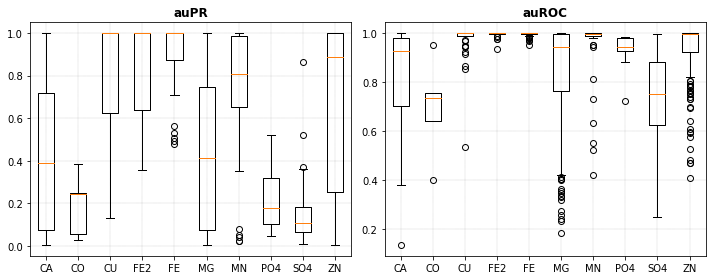

In [16]:
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
#model_name = 'esm1_t6_43M_UR50S'

for fold in range(1,6):
    print('Analysing fold %s...'%(fold))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
    trained_model.load_state_dict(torch.load('checkpoints/%s_setB_fold%s.pt'%(model_name, fold)))
    trained_model.eval()

    count=0

    val_performance_dict = {'aupr':{k: [] for k in df['LigID'].unique()}, 
                            'auroc':{k: [] for k in df['LigID'].unique()},
                            'precision':{k: [] for k in df['LigID'].unique()},
                            'recall':{k: [] for k in df['LigID'].unique()},
                            'thresholds':{k: [] for k in df['LigID'].unique()}
                            }

    fields = list(collections.Counter(df['LigID']).keys())
    fields.append('null')
    label_dict = dict.fromkeys(fields, [])
    inference_dict = dict.fromkeys(df[df['partitions']==6]['pdb_chain'].values)

    for pdbid in tqdm(df[df['partitions']==6]['pdb_chain'].values): # Run inference on partition 6
        emb = torch.load(model_name+'/'+pdbid+'.pt')
        key = list(emb['representations'].keys())
        emb = emb['representations'][key[0]]

        label_list = [int(a) for a in data_dict[pdbid][1]]
        label_dict = dict.fromkeys(fields, np.array([0]*len(emb)))
        label_dict[data_dict[pdbid][2]] = np.array(label_list)
        null_label = np.ones(len(label_list))
        null_label[np.where(label_list==1)[0]]=0
        label_dict['null'] = null_label
        
        #print(emb.shape, len(label_dict))
        predictions = trained_model(emb.to(device), mask=None)

        import torch.nn as nn
        m = nn.Sigmoid()
        predictions_ = torch.round(m(torch.stack(predictions)))
        inference_dict[pdbid]={'predictions':predictions_.cpu().data.numpy(),
                               'labels':label_dict, 
                               'predictions_logits':m(torch.stack(predictions)).cpu().data.numpy()}

        for ion, i in zip(df['LigID'].unique(), range(len(df['LigID'].unique()))):
            if ion=='null':
                continue
            try:
                roc_auc = roc_auc_score(np.array(label_dict[ion]), m(predictions[i]).cpu().data.numpy())
                fpr, tpr, threshold = roc_curve(np.array(label_dict[ion]), m(predictions[i]).cpu().data.numpy())
                precision, recall, thresholds = precision_recall_curve(np.array(label_dict[ion]), m(predictions[i]).cpu().data.numpy())
                aupr = average_precision_score(np.array(label_dict[ion]), m(predictions[i]).cpu().data.numpy())
                val_performance_dict['aupr'][ion].append(aupr)
                val_performance_dict['auroc'][ion].append(roc_auc)
                #val_performance_dict['precision'][ion].append(precision)
                #val_performance_dict['recall'][ion].append(recall)
                #val_performance_dict['thresholds'][ion].append(thresholds)

                #print(ion, 'aupr:', aupr, ', auroc:', roc_auc)
            except:
                pass

    # print statistics
    print('ion, aupr, auroc')
    for ion in df['LigID'].unique():
        print(ion, np.round(np.array(val_performance_dict['aupr'][ion]).mean(),3),
                   np.round(np.array(val_performance_dict['auroc'][ion]).mean(),3))

    # Plot model performances on holdout set
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].boxplot(val_performance_dict['aupr'].values())
    ax[0].set_xticklabels(val_performance_dict['aupr'].keys())
    ax[0].set_title('auPR', fontweight='bold')
    ax[0].grid(color='black', linestyle='-.', linewidth=0.1)
    #plt.show()

    #fig, ax = plt.subplots()
    ax[1].boxplot(val_performance_dict['auroc'].values())
    ax[1].set_xticklabels(val_performance_dict['auroc'].keys())
    ax[1].set_title('auROC', fontweight='bold')
    ax[1].grid(color='black', linestyle='-.', linewidth=0.1)

    plt.tight_layout()
    plt.show()
    break

In [4]:
with open('inference_dict_fold6_%s.pkl'%(model_name), 'rb') as f:
    inference_dict = pickle.load(f)

100%|██████████| 1121/1121 [00:02<00:00, 393.52it/s]


ion, aupr, auroc
CA 0.429 0.838
CO 0.193 0.696
CU 0.81 0.971
FE2 0.845 0.993
FE 0.919 0.995
MG 0.43 0.851
MN 0.748 0.943
PO4 0.231 0.927
SO4 0.17 0.713
ZN 0.677 0.946


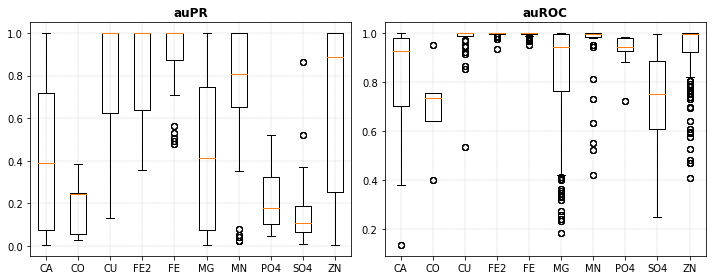

In [24]:
for pdbid in tqdm(inference_dict.keys()):
    label_dict = inference_dict[pdbid]['labels']
    predictions = inference_dict[pdbid]['predictions']
    predictions_logits = inference_dict[pdbid]['predictions_logits']

    for ion, i in zip(label_dict.keys(), range(len(label_dict.keys()))):
        if ion=='null':
            continue
        try:
            roc_auc = roc_auc_score(np.array(label_dict[ion]), predictions_logits[i])
            fpr, tpr, threshold = roc_curve(np.array(label_dict[ion]), predictions_logits[i])
            precision, recall, thresholds = precision_recall_curve(np.array(label_dict[ion]), predictions_logits[i])
            aupr = average_precision_score(np.array(label_dict[ion]), predictions_logits[i])
            val_performance_dict['aupr'][ion].append(aupr)
            val_performance_dict['auroc'][ion].append(roc_auc)
        except:
            pass
# print statistics
print('ion, aupr, auroc')
for ion in df['LigID'].unique():
    print(ion, np.round(np.array(val_performance_dict['aupr'][ion]).mean(),3),
                np.round(np.array(val_performance_dict['auroc'][ion]).mean(),3))

# Plot model performances on holdout set
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].boxplot(val_performance_dict['aupr'].values())
ax[0].set_xticklabels(val_performance_dict['aupr'].keys())
ax[0].set_title('auPR', fontweight='bold')
ax[0].grid(color='black', linestyle='-.', linewidth=0.1)
#plt.show()

#fig, ax = plt.subplots()
ax[1].boxplot(val_performance_dict['auroc'].values())
ax[1].set_xticklabels(val_performance_dict['auroc'].keys())
ax[1].set_title('auROC', fontweight='bold')
ax[1].grid(color='black', linestyle='-.', linewidth=0.1)

plt.tight_layout()
plt.show()

### Training statistics

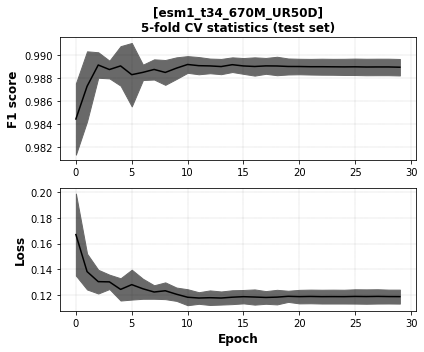

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
model_name = 'esm1_t34_670M_UR50D'
list_f1, list_loss = [], []
for fold in range(1,6):
    df = pd.read_csv('checkpoints/%s_setB_fold%s.csv'%(model_name, fold))
    list_f1.append(list(df['net_f1_test']))
    list_loss.append(list(df['net_loss_test']))

test_mean_f1 = np.mean(list_f1, axis=0)
test_std_f1 = np.std(list_f1, axis=0)

test_mean_loss = np.mean(list_loss, axis=0)
test_std_loss = np.std(list_loss, axis=0)

fig, ax = plt.subplots(2, figsize=(6,5))
ax[0].plot(range(len(test_mean_f1)), test_mean_f1, label="Training score", color="black")
ax[0].fill_between(range(len(test_mean_f1)), test_mean_f1 - test_std_f1, test_mean_f1 + test_std_f1, color="dimgrey")
ax[0].set_ylabel('F1 score', fontsize=12, fontweight='bold')
ax[0].grid(color='black', linestyle='-.', linewidth=0.1)

ax[1].plot(range(len(test_mean_loss)), test_mean_loss, label="Training score", color="black")
ax[1].fill_between(range(len(test_mean_loss)), test_mean_loss - test_std_loss, test_mean_loss + test_std_loss, color="dimgrey")
ax[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax[1].grid(color='black', linestyle='-.', linewidth=0.1)

ax[0].set_title('[%s]\n5-fold CV statistics (test set)'%(model_name), fontsize=12, fontweight='bold')
plt.tight_layout()

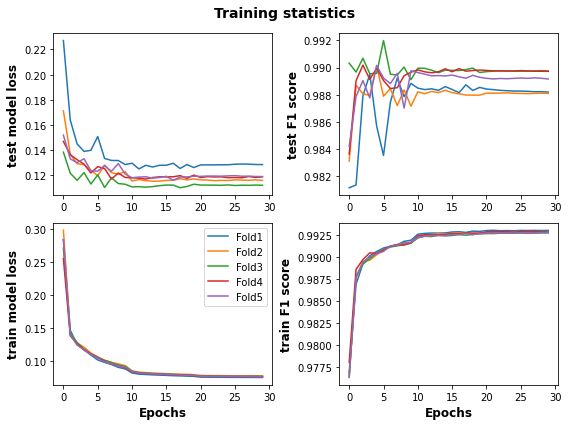

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
model_name = 'esm1_t34_670M_UR50D'
fig, ax = plt.subplots(2,2, figsize=(8, 6))
for fold in range(1,6):
    df = pd.read_csv('checkpoints/%s_setB_fold%s.csv'%(model_name, fold))
    ax[0][0].plot(range(len(df['net_loss_test'])), df['net_loss_test'], label='Fold%s'%(fold))
    ax[0][0].set_ylabel('test model loss', fontsize=12, fontweight='bold')
    
    ax[0][1].plot(range(len(df['net_f1_test'])), df['net_f1_test'], label='Fold%s'%(fold))
    ax[0][1].set_ylabel('test F1 score', fontsize=12, fontweight='bold')

    ax[1][0].plot(range(len(df['net_loss_train'])), df['net_loss_train'], label='Fold%s'%(fold))
    ax[1][0].set_ylabel('train model loss', fontsize=12, fontweight='bold')
    ax[1][0].legend()

    ax[1][1].plot(range(len(df['net_f1_train'])), df['net_f1_train'], label='Fold%s'%(fold))
    ax[1][1].set_ylabel('train F1 score', fontsize=12, fontweight='bold')
    
    ax[1][1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[1][0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
fig.suptitle('Training statistics', fontsize=14, fontweight='bold')
plt.tight_layout()